In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import get_file
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [2]:
# --- Load Dataset ---
cols = ['userId', 'movieId', 'rating', 'timestamp']
movies = tfds.load("movielens/100k-movies", split="train")
movies_df = tfds.as_dataframe(movies)

In [3]:
# Decode byte strings
movies_df['movie_id'] = movies_df['movie_id'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
movies_df['movie_title'] = movies_df['movie_title'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
movies_df['movie_id'] = movies_df['movie_id'].astype(int)
movies_df.rename(columns={'movie_id': 'movieId'}, inplace=True)

In [4]:
# Map genres
genre_map = {
    0: 'Action', 1: 'Adventure', 2: 'Animation', 3: 'Children', 4: 'Comedy',
    5: 'Crime', 6: 'Documentary', 7: 'Drama', 8: 'Fantasy', 9: 'Film-Noir',
    10: 'Horror', 11: 'Musical', 12: 'Mystery', 13: 'Romance', 14: 'Sci-Fi',
    15: 'Thriller', 16: 'War', 17: 'Western'
}
movies_df['genre_names'] = movies_df['movie_genres'].apply(lambda genre_ids: [genre_map.get(gid, 'Unknown') for gid in genre_ids])
movies_df.head()

,movie_genres,movieId,movie_title,genre_names
0,[4],1681,You So Crazy (1994),[Comedy]
1,"[4, 7]",1457,Love Is All There Is (1996),"[Comedy, Drama]"
2,"[1, 3]",500,Fly Away Home (1996),"[Adventure, Children]"
3,[0],838,In the Line of Duty 2 (1987),[Action]
4,[7],1648,"Niagara, Niagara (1997)",[Drama]


In [5]:

df = pd.read_csv(r'C:\Users\EIG_Lab(1)\Documents\ml-100k\ml-100k\u.data', sep='\t', names=cols)



In [6]:
# Encode IDs
user2user_encoded = {x: i for i, x in enumerate(df['userId'].unique())}
movie2movie_encoded = {x: i for i, x in enumerate(df['movieId'].unique())}
df['user'] = df['userId'].map(user2user_encoded)
df['movie'] = df['movieId'].map(movie2movie_encoded)
df.head()

,userId,movieId,rating,timestamp,user,movie
0,196,242,3,881250949,0,0
1,186,302,3,891717742,1,1
2,22,377,1,878887116,2,2
3,244,51,2,880606923,3,3
4,166,346,1,886397596,4,4


In [7]:

num_movies = len(movie2movie_encoded)
num_movies

1682

In [8]:
num_users = len(user2user_encoded)
num_users


943

In [9]:
# Normalize ratings
min_rating, max_rating = df['rating'].min(), df['rating'].max()
df['rating'] = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

In [10]:
# --- Train-test Split ---
X = df[['user', 'movie']].values
y = df['rating'].values
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [11]:
# --- Define Model ---
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super().__init__()
        self.user_embedding = Embedding(num_users, embedding_size)
        self.movie_embedding = Embedding(num_movies, embedding_size)
        self.user_bias = Embedding(num_users, 1)
        self.movie_bias = Embedding(num_movies, 1)

    def call(self, inputs):
        user_vec = self.user_embedding(inputs[:, 0])
        movie_vec = self.movie_embedding(inputs[:, 1])
        user_bias = self.user_bias(inputs[:, 0])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot = tf.tensordot(user_vec, movie_vec, 2)
        return tf.nn.sigmoid(dot + user_bias + movie_bias)


In [12]:
model = RecommenderNet(num_users, num_movies, embedding_size=50)

In [13]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [14]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [15]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),)

Epoch 1/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.2007 - loss: 0.6623 - precision: 0.9463 - recall: 0.8723 - val_accuracy: 0.2211 - val_loss: 0.6280 - val_precision: 0.9479 - val_recall: 0.9717
Epoch 2/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.2284 - loss: 0.6234 - precision: 0.9554 - recall: 0.9461 - val_accuracy: 0.2333 - val_loss: 0.6193 - val_precision: 0.9619 - val_recall: 0.8735
Epoch 3/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.2359 - loss: 0.6156 - precision: 0.9653 - recall: 0.8810 - val_accuracy: 0.2343 - val_loss: 0.6168 - val_precision: 0.9646 - val_recall: 0.8395
Epoch 4/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.2388 - loss: 0.6135 - precision: 0.9665 - recall: 0.8451 - val_accuracy: 0.2346 - val_loss: 0.6163 - val_precision: 0.9653 - val_recall: 0.8144
Epoch 5/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2393 - loss: 0.6116 - precision: 0.9701 - recall: 0.8284 - val_accuracy: 0.2356

In [16]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Predict probabilities
y_pred_probs = model.predict(x_val)

# Convert probabilities to binary (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)

# Convert y_val to binary if it's not already
y_val_binary = (y_val > 0.5).astype(int)

# Now compute metrics
precision = precision_score(y_val_binary, y_pred)
recall = recall_score(y_val_binary, y_pred)
accuracy = accuracy_score(y_val_binary, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Precision: 0.65
Recall: 0.89
Accuracy: 0.67


In [17]:
# --- Recommendation for a Random User ---
user_id = df['userId'].sample(1).iloc[0]
movies_watched = df[df.userId == user_id]
not_watched = df[~df['movieId'].isin(movies_watched.movieId.values)]['movieId'].unique()
not_watched = [[movie2movie_encoded.get(x)] for x in not_watched if x in movie2movie_encoded]
user_encoded = user2user_encoded.get(user_id)
user_movie_array = np.hstack(([[user_encoded]] * len(not_watched), not_watched))
ratings = model.predict(user_movie_array).flatten()
top_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [list(movie2movie_encoded.keys())[list(movie2movie_encoded.values()).index(not_watched[x][0])] for x in top_indices]
recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [18]:
print("Top 10 Recommendations:")
recommended_movies[['movie_title', 'genre_names']]

Top 10 Recommendations:


,movie_title,genre_names
170,High Noon (1952),[Unknown]
274,Dr. Strangelove or: How I Learned to Stop Worr...,"[Thriller, Unknown]"
609,Titanic (1997),"[Action, Drama, Sci-Fi]"
635,"Third Man, The (1949)","[Romance, War]"
652,One Flew Over the Cuckoo's Nest (1975),[Drama]
1072,Schindler's List (1993),"[Drama, Unknown]"
1142,Citizen Kane (1941),[Drama]
1194,"Manchurian Candidate, The (1962)","[Film-Noir, War]"
1411,Paradise Lost: The Child Murders at Robin Hood...,[Documentary]
1479,"Shawshank Redemption, The (1994)",[Drama]


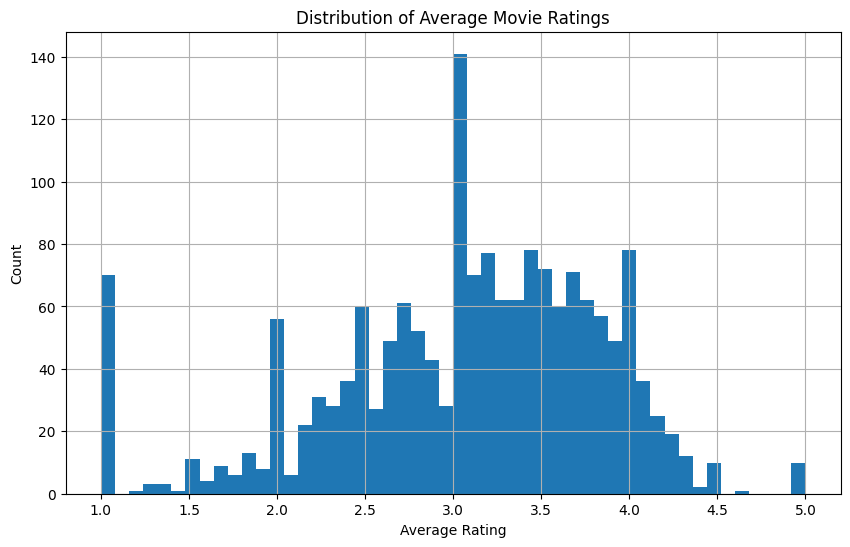

In [19]:
# --- Graphs ---
plt.figure(figsize=(10,6))
df['rating_original'] = df['rating'] * (max_rating - min_rating) + min_rating
df.groupby('movieId')['rating_original'].mean().hist(bins=50)
plt.title('Distribution of Average Movie Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

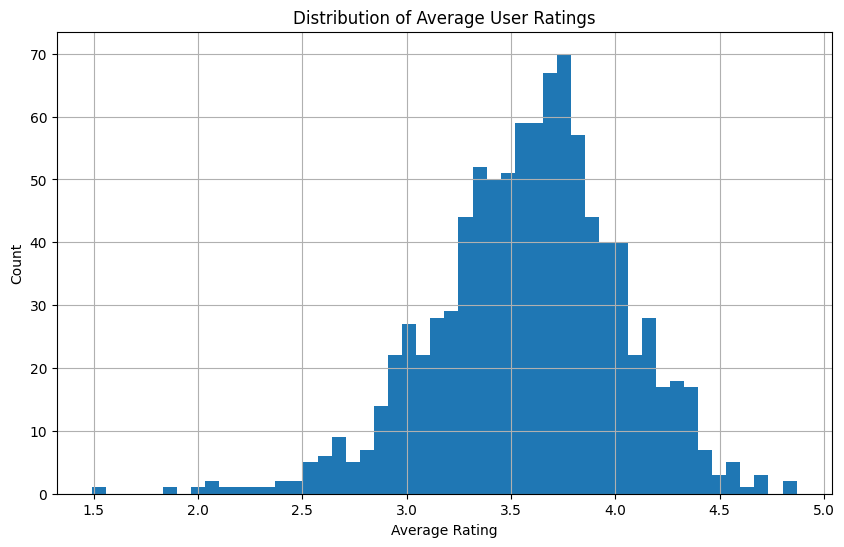

In [20]:
plt.figure(figsize=(10,6))
df.groupby('userId')['rating_original'].mean().hist(bins=50)
plt.title('Distribution of Average User Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

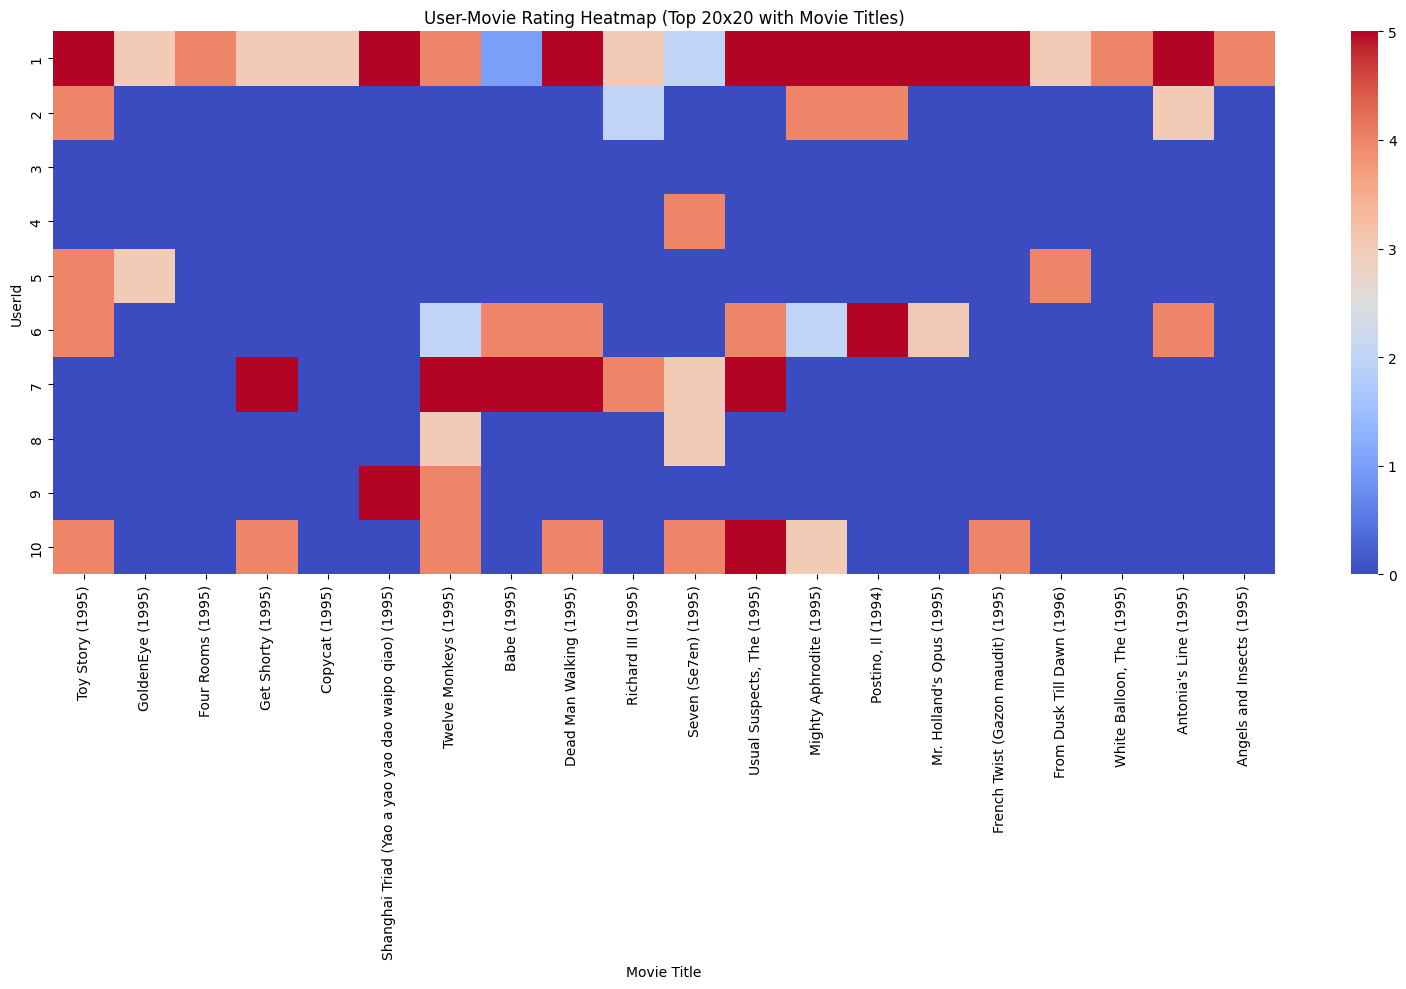

In [21]:
# --- Heatmap ---
pivot_df = df.pivot(index='userId', columns='movieId', values='rating_original').fillna(0)
movie_id_to_title = dict(zip(movies_df['movieId'], movies_df['movie_title']))
pivot_df.columns = [movie_id_to_title.get(mid, str(mid)) for mid in pivot_df.columns]
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_df.iloc[:10, :20], cmap='coolwarm')
plt.title('User-Movie Rating Heatmap (Top 20x20 with Movie Titles)')
plt.xlabel('Movie Title')
plt.ylabel('UserId')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()